## Delta hedging of a sold European call

Business context: 
- We sold a customer a 1-M call on an index (ATM).
- We hedge the underlying via delta.


**Goal:** Can a *discrete* delta hedge replicate a European call under Black–Scholes?  
We study how hedging error depends on:
- **Rebalancing frequency:** daily vs. weekly
- **Volatility mis-specification:** using a hedge vol `sigma_hedge` different from true vol `sigma_true`

**Setup.**
- Underlying follows a **Geometric Brownian Motion (GBM)** with constant volatility `sigma_true` under risk-neutral drift `μ = r − q`.
- We short 1× European **call** at time 0 and hedge with the **stock**.
- At each rebalance time we set the hedge to the **Black–Scholes delta** computed with model vol `sigma_hedge`.
- Cash accrues at the continuous rate `r`.

**Portfolio and hedging error.**
Let `V_t` be option value, `Delta_t` the hedge ratio, `S_t` the stock price, and `B_t` the cash account.
We track the self-financing portfolio
`H_t = -V_t + \Delta_t S_t + B_t`,
with `B` accruing at `e^{r\,\Delta t}` and trades `Delta` rebalanced discretely (daily/weekly).
The **terminal hedging error** is
`H_T = -\text{payoff} + \Delta_T S_T + B_T.`
With continuous rebalancing and correct volatility, `H_T=0`. In practice, discretization and model error imply `H_T \neq 0`.



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from qp import bs_price, bs_greeks 

#---- Parameters ----
# Underlying and Option
S0 = 100.0              # initial spot 
K = 100.0               # strike    
r = 0.02                # risk-free
q = 0.00              # dividend yield 
T = 1.0                 # time to maturity in years
option_type = "call"    

sigma_true = 0.20       # "realized" vol used in GBM 
sigma_hedge = 0.20      # model vol 

days_per_year = 252 
dt = 1.0 / days_per_year
n_steps = int(T * days_per_year)

rng = np.random.default_rng(7)

<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

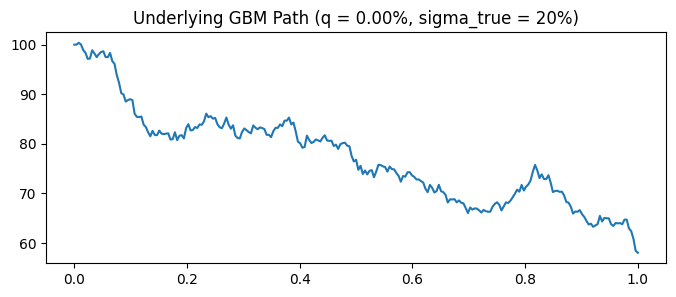

In [2]:
# GBM simulation under risk-neutral drift mu = r - q
def simulate_gbm(
        S0: float, 
        mu: float, 
        sigma: float, 
        dt: float, 
        n_steps: int, 
        rng
) -> np.ndarray:
    """
    One GBM path: dS = mu * S * dt + sigma * S * dW.
    We discretize: log-returns per step are Normal with mean (mu - 0.5*sigma^2)*dt
    and std sigma*sqrt(dt).
    """
    Z = rng.standard_normal(n_steps)
    increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    S = np.empty(n_steps + 1)
    S[0] = S0
    S[1:] = S0 * np.exp(np.cumsum(increments))
    return S

# simulate ONE path
S_path = simulate_gbm(S0, r - q, sigma_true, dt, n_steps, rng)


tgrid = np.arange(n_steps + 1) * dt
plt.figure(figsize=(8,3))
plt.plot(tgrid, S_path)
plt.title(f"Underlying GBM Path (q = {q:.2%}, sigma_true = {sigma_true:.0%})")
plt.xlabel

In [3]:
def delta_hedge_one_path(
    S_path: np.ndarray,
    S0: float, K: float, r: float, q: float,
    sigma_hedge: float, T: float, option_type: str,
    dt: float, rebalance_steps: int = 1
):
    """
    Discrete self-financing delta hedging for a short 1x option on a single path.

    - Initialize at t=0: short option (receive V0), buy delta0 shares, cash = V0 - delta0*S0
    - Each step: accrue cash with exp(r*dt), optionally rebalance delta
    - Track portfolio H_t = -V_t + delta_t * S_t + B_t
    - Return time series and terminal hedging error H_T (vs. payoff)
    """
    n_steps = len(S_path) - 1

    # t=0: price & delta using model sigma_hedge
    V0 = bs_price(S0, K, r, q, sigma_hedge, T, option_type)
    g0 = bs_greeks(S0, K, r, q, sigma_hedge, T, option_type)
    delta = g0["delta"]              
    B = V0 - delta * S0               # cash after buying shares

    # storage 
    deltas = np.zeros(n_steps + 1)
    cash   = np.zeros(n_steps + 1)
    optval = np.zeros(n_steps + 1)
    H      = np.zeros(n_steps + 1)

    deltas[0] = delta
    cash[0]   = B
    optval[0] = V0
    H[0]      = -V0 + delta * S0 + B   

    
    for t in range(n_steps):
        
        B *= np.exp(r * dt)

        # current state
        S_t = S_path[t]
        tau = max(T - t*dt, 0.0)

        # rebalance at chosen frequency 
        if (t % rebalance_steps == 0) or (t == n_steps - 1):
            g = bs_greeks(S_t, K, r, q, sigma_hedge, tau, option_type)
            delta_new = g["delta"]
            trade = delta_new - delta
            B -= trade * S_t          # buy/sell stock to reach new delta
            delta = delta_new

        # mark to market the option & portfolio
        V_t = bs_price(S_t, K, r, q, sigma_hedge, tau, option_type)
        H_t = -V_t + delta * S_t + B

        
        deltas[t+1] = delta
        cash[t+1]   = B
        optval[t+1] = V_t
        H[t+1]      = H_t

    # terminal hedging error vs. payoff
    ST = S_path[-1]
    payoff = max(ST - K, 0.0) if option_type == "call" else max(K - ST, 0.0)
    H_T = -payoff + delta * ST + B

    return {
        "deltas": deltas,
        "cash": cash,
        "option": optval,
        "portfolio": H,
        "hedge_error_T": float(H_T),
    }

# run on single path
res = delta_hedge_one_path(
    S_path, S0, K, r, q, sigma_hedge, T, option_type,
    dt=dt, rebalance_steps=1  # daily
)

res["hedge_error_T"]

0.28502193424003475

## Monte Carlo Simulation for mean, std and MSHE

In [4]:
def mc_hedge_errors(
    N: int,
    rebalance_steps: int,
    sigma_hedge: float,
    *,
    S0=S0, K=K, r=r, q=q, T=T, option_type=option_type,
    dt=dt, n_steps=n_steps
):
    """Simulate N paths, return terminal hedging error and MSHE ."""
    rng_local = np.random.default_rng(123)
    errors = np.empty(N, dtype=float)
    for i in range(N):
        # simulate one GBM path under risk-neutral drift
        Z = rng_local.standard_normal(n_steps)
        increments = (r - q - 0.5 * sigma_true**2) * dt + sigma_true * np.sqrt(dt) * Z
        S = np.empty(n_steps + 1)
        S[0] = S0
        S[1:] = S0 * np.exp(np.cumsum(increments))

        out = delta_hedge_one_path(
            S, S0, K, r, q, sigma_hedge, T, option_type, dt, rebalance_steps
        )
        errors[i] = out["hedge_error_T"]
    mshe = float(np.mean(errors**2))
    return errors, mshe


scenarios = [
    ("daily, correct vol",   1,   sigma_true),
    ("weekly, correct vol",  5,   sigma_true),
    ("daily, 0.8× vol",      1,   0.8 * sigma_true),
    ("daily, 1.2× vol",      1,   1.2 * sigma_true),
]

records = []
all_errors = {}

for name, step, sig_h in scenarios:
    errs, mshe = mc_hedge_errors(N=500, rebalance_steps=step, sigma_hedge=sig_h)
    all_errors[name] = errs
    records.append({
        "scenario": name,
        "rebalance_steps": step,
        "sigma_hedge": sig_h,
        "mean_H_T": float(np.mean(errs)),
        "std_H_T": float(np.std(errs, ddof=1)),
        "MSHE": mshe
    })

df_results = pd.DataFrame(records).sort_values("scenario").reset_index(drop=True)
df_results

,scenario,rebalance_steps,sigma_hedge,mean_H_T,std_H_T,MSHE
0,"daily, 0.8× vol",1,0.16,-1.580067,0.789769,3.119100
1,"daily, 1.2× vol",1,0.24,1.635646,0.742894,3.226124
2,"daily, correct vol",1,0.20,0.029303,0.453777,0.206361
3,"weekly, correct vol",5,0.20,0.044433,0.959640,0.921042


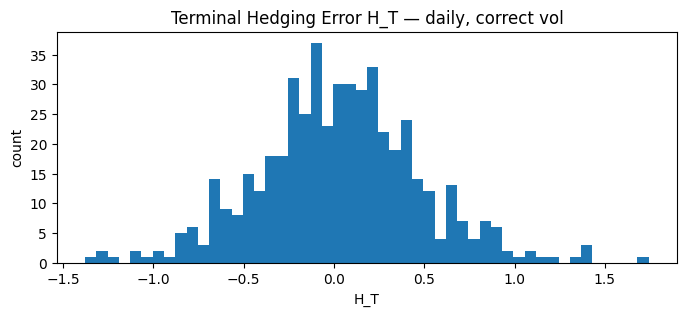

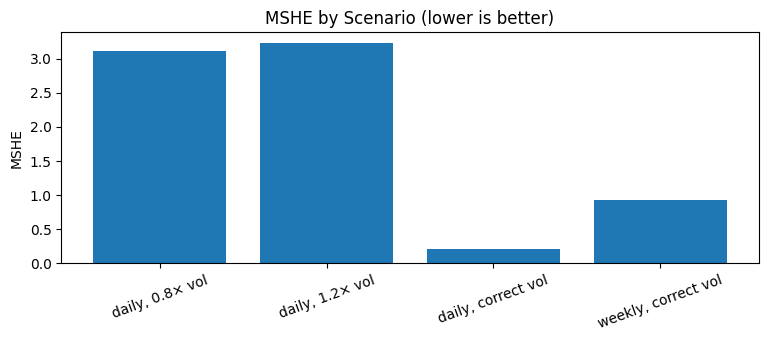

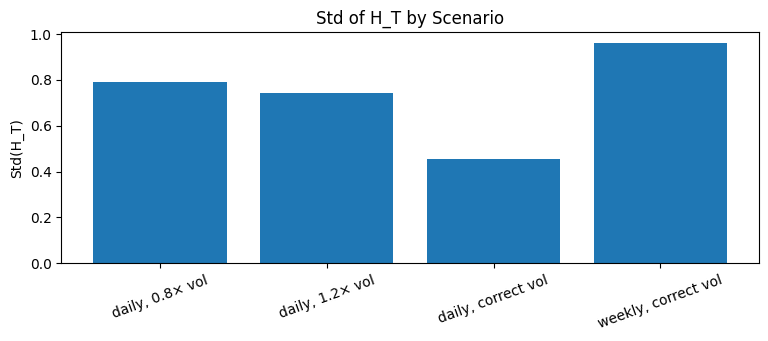

In [5]:
errs_example = all_errors["daily, correct vol"]
plt.figure(figsize=(8,3))
plt.hist(errs_example, bins=50)
plt.title("Terminal Hedging Error H_T — daily, correct vol")
plt.xlabel("H_T"); plt.ylabel("count")
plt.show()

plt.figure(figsize=(9,3))
plt.bar(df_results["scenario"], df_results["MSHE"])
plt.title("MSHE by Scenario (lower is better)")
plt.xticks(rotation=20)
plt.ylabel("MSHE")
plt.show()

plt.figure(figsize=(9,3))
plt.bar(df_results["scenario"], df_results["std_H_T"])
plt.title("Std of H_T by Scenario")
plt.xticks(rotation=20)
plt.ylabel("Std(H_T)")
plt.show()

The results confirm that discrete hedging produces residual error even with the correct model, and that hedging less frequently (weekly) significantly increases risk. More importantly, using a mis-specified volatility leads to systematic P&L bias – highlighting the importance of model risk for option desks

## Implementing Transaction Costs, VaR, CVaR and Moneyness sweep 

In [6]:
def delta_hedge_one_path(
    S_path: np.ndarray,
    S0: float, K: float, r: float, q: float,
    sigma_hedge: float, T: float, option_type: str,
    dt: float, rebalance_steps: int = 1,
    tc_bps: float = 0.0,   # transaction cost in basis points (per traded notional)
):
    """
    Discrete self-financing delta hedge for a short 1x option.
    Adds linear transaction costs: cost = |trade| * S_t * (tc_bps / 1e4).
    Returns series + terminal H_T and also turnover & total_cost.
    """
    n_steps = len(S_path) - 1

    V0 = bs_price(S0, K, r, q, sigma_hedge, T, option_type)
    delta = bs_greeks(S0, K, r, q, sigma_hedge, T, option_type)["delta"]
    B = V0 - delta * S0

    deltas = np.zeros(n_steps + 1); deltas[0] = delta
    cash   = np.zeros(n_steps + 1); cash[0]   = B
    optval = np.zeros(n_steps + 1); optval[0] = V0
    H      = np.zeros(n_steps + 1); H[0]      = -V0 + delta * S0 + B

    turnover = 0.0
    total_cost = 0.0
    cost_rate = tc_bps / 1e4

    for t in range(n_steps):
        B *= np.exp(r * dt)
        S_t = S_path[t]
        tau = max(T - t*dt, 0.0)

        if (t % rebalance_steps == 0) or (t == n_steps - 1):
            delta_new = bs_greeks(S_t, K, r, q, sigma_hedge, tau, option_type)["delta"]
            trade = delta_new - delta
            if trade != 0.0:
                # pay transaction cost on traded notional
                cost = abs(trade) * S_t * cost_rate
                B -= trade * S_t
                B -= cost
                turnover   += abs(trade) * S_t
                total_cost += cost
                delta = delta_new

        V_t = bs_price(S_t, K, r, q, sigma_hedge, tau, option_type)
        H_t = -V_t + delta * S_t + B

        deltas[t+1] = delta; cash[t+1] = B; optval[t+1] = V_t; H[t+1] = H_t

    ST = S_path[-1]
    payoff = max(ST - K, 0.0) if option_type == "call" else max(K - ST, 0.0)
    H_T = -payoff + delta * ST + B

    return {
        "deltas": deltas, "cash": cash, "option": optval, "portfolio": H,
        "hedge_error_T": float(H_T),
        "turnover": float(turnover),
        "total_cost": float(total_cost),
    }

In [7]:
def mc_hedge_errors(
    N: int, rebalance_steps: int, sigma_hedge: float, tc_bps: float = 0.0,
    *, S0=S0, K=K, r=r, q=q, T=T, option_type=option_type, dt=dt, n_steps=n_steps
):
    rng_local = np.random.default_rng(123)
    errors = np.empty(N); turns = np.empty(N); costs = np.empty(N)
    for i in range(N):
        Z = rng_local.standard_normal(n_steps)
        inc = (r - q - 0.5 * sigma_true**2) * dt + sigma_true * np.sqrt(dt) * Z
        S = np.empty(n_steps + 1); S[0] = S0; S[1:] = S0 * np.exp(np.cumsum(inc))

        out = delta_hedge_one_path(S, S0, K, r, q, sigma_hedge, T, option_type,
                                   dt, rebalance_steps, tc_bps=tc_bps)
        errors[i] = out["hedge_error_T"]
        turns[i]  = out["turnover"]
        costs[i]  = out["total_cost"]
    mshe = float(np.mean(errors**2))
    return errors, mshe, turns, costs

In [8]:
from qp import var_historical, es_historical 

scenarios = [
    ("daily, correct vol, 0bps",   1, sigma_true, 0.0),
    ("daily, correct vol, 10bps",  1, sigma_true, 10.0),
    ("weekly, correct vol, 0bps",  5, sigma_true, 0.0),
    ("weekly, correct vol, 10bps", 5, sigma_true, 10.0),
]

recs = []; errs_map = {}
for name, step, sig_h, tc in scenarios:
    errs, mshe, turns, costs = mc_hedge_errors(400, step, sig_h, tc_bps=tc)
    recs.append({
        "scenario": name,
        "rebalance_steps": step,
        "tc_bps": tc,
        "MSHE": mshe,
        "mean_H_T": float(np.mean(errs)),
        "std_H_T": float(np.std(errs, ddof=1)),
        "mean_turnover": float(np.mean(turns)),
        "mean_cost": float(np.mean(costs)),
    })
    errs_map[name] = errs

df_cost = pd.DataFrame(recs)
df_cost

,scenario,rebalance_steps,tc_bps,MSHE,mean_H_T,std_H_T,mean_turnover,mean_cost
0,"daily, correct vol, 0bps",1,0.0,0.192443,0.019160,0.438813,502.061568,0.000000
1,"daily, correct vol, 10bps",1,10.0,0.463778,-0.487863,0.475745,502.061568,0.502062
2,"weekly, correct vol, 0bps",5,0.0,0.916125,0.010107,0.958289,228.875349,0.000000
3,"weekly, correct vol, 10bps",5,10.0,0.990334,-0.220958,0.971530,228.875349,0.228875


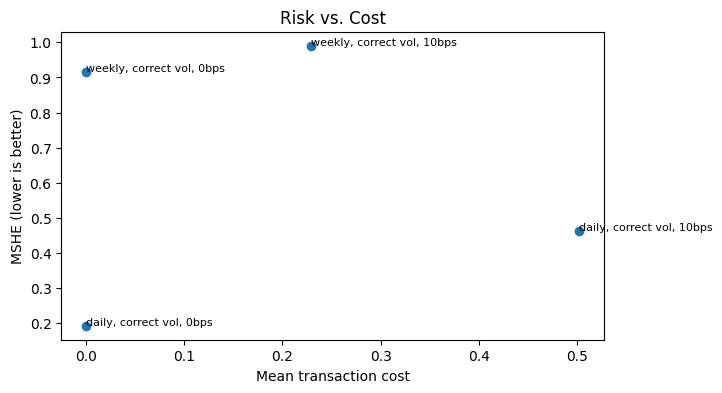

In [9]:
plt.figure(figsize=(7,4))
plt.scatter(df_cost["mean_cost"], df_cost["MSHE"])
for i, row in df_cost.iterrows():
    plt.annotate(row["scenario"], (row["mean_cost"], row["MSHE"]), fontsize=8)
plt.xlabel("Mean transaction cost"); plt.ylabel("MSHE (lower is better)")
plt.title("Risk vs. Cost")
plt.show()

In [10]:
def risk_metrics(errors: np.ndarray, level=0.99):
    # errors = terminal hedging errors H_T
    vaR = var_historical(errors, level=level, input_is_loss=False)
    es  = es_historical(errors, level=level, input_is_loss=False)
    return float(vaR), float(es)

rows = []
for name, arr in errs_map.items():
    vaR99, es99 = risk_metrics(arr, level=0.99)
    rows.append({"scenario": name, "VaR(99%)": vaR99, "ES(99%)": es99})
pd.DataFrame(rows).sort_values("scenario")

,scenario,VaR(99%),ES(99%)
0,"daily, correct vol, 0bps",0.977428,1.104173
1,"daily, correct vol, 10bps",1.678224,1.796033
2,"weekly, correct vol, 0bps",2.501929,2.765224
3,"weekly, correct vol, 10bps",2.811938,3.121370


In [11]:
def study_moneyness(moneyness_list=(0.9, 1.0, 1.1), rebalance_steps=1, tc_bps=0.0):
    recs = []
    for m in moneyness_list:
        K_local = S0 * m
        errs, mshe, turns, costs = mc_hedge_errors(400, rebalance_steps, sigma_true, tc_bps=tc_bps,
                                                   S0=S0, K=K_local, r=r, q=q, T=T,
                                                   option_type=option_type, dt=dt, n_steps=n_steps)
        recs.append({"moneyness K/S0": m, "MSHE": mshe,
                     "std_H_T": float(np.std(errs, ddof=1)),
                     "mean_cost": float(np.mean(costs))})
    return pd.DataFrame(recs).sort_values("moneyness K/S0")

df_mny = study_moneyness(moneyness_list=(0.9, 1.0, 1.1), rebalance_steps=1, tc_bps=0.0)
df_mny

,moneyness K/S0,MSHE,std_H_T,mean_cost
0,0.9,0.121577,0.348841,0.0
1,1.0,0.192443,0.438813,0.0
2,1.1,0.219715,0.469270,0.0


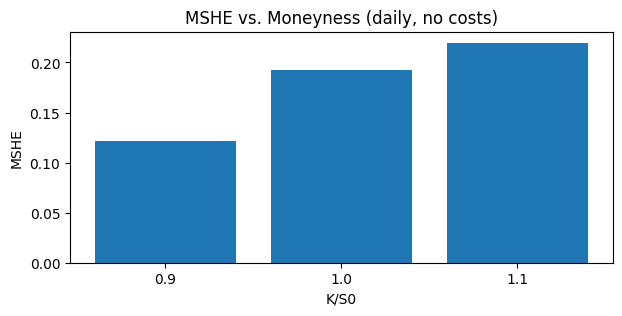

In [12]:
plt.figure(figsize=(7,3))
plt.bar(df_mny["moneyness K/S0"].astype(str), df_mny["MSHE"])
plt.title("MSHE vs. Moneyness (daily, no costs)"); plt.xlabel("K/S0"); plt.ylabel("MSHE")
plt.show()